In [89]:
# Update sklearn to prevent version mismatches
!pip install sklearn --upgrade
# install joblib. This will be used to save your model. 
# Restart your kernel after installing 
!pip install joblib

This model uses a neural network and GridSearchCV to predict share price impacts of Interest changes

# Read the CSV and Perform Basic Data Cleaning

In [90]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [91]:
df_stock1 = pd.read_csv("../../static/data/CSL.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df_stock3 = df_stock2.dropna()
# Drop the last row to test prediction to actual
df_stock_less1= df_stock3.iloc[:-1,:]
# Drop last 3 columns Sentiment RBA FED
# N=3
# df = df_stock_less1.iloc[: , :-N]
df_stock_less1.head()

,Date,Open,High,Low,Close,Adj Close,Volume,SENTIMENT,RBA,FED,CPI
0,3/01/2000,7.300000,7.300000,7.300000,7.300000,5.234562,0.0,NEGATIVE,5.0,5.5,69.7
1,4/01/2000,7.333333,7.333333,7.066666,7.186666,5.153295,254295.0,NEGATIVE,5.0,5.5,69.7
2,5/01/2000,7.000000,7.183333,7.000000,7.155000,5.130589,424941.0,NEGATIVE,5.0,5.5,69.7
3,6/01/2000,7.233333,7.273333,7.000000,7.000000,5.019443,348534.0,NEGATIVE,5.0,5.5,69.7
4,7/01/2000,7.013000,7.023333,6.800000,6.850000,4.911883,483963.0,POSITIVE,5.0,5.5,69.7


In [92]:
df_stock_less1.shape

(5687, 11)

# Use `RBA`,`FED` and `CPI` for the X values

In [93]:
X = df_stock_less1[["RBA","FED","CPI"]]
y = df_stock_less1["Close"].values.reshape(-1, 1)
print(X.shape, y.shape)

(5687, 3) (5687, 1)


In [94]:
X

,RBA,FED,CPI
0,5.00,5.50,69.7
1,5.00,5.50,69.7
2,5.00,5.50,69.7
3,5.00,5.50,69.7
4,5.00,5.50,69.7
...,...,...,...
5717,0.85,1.75,125.0
5718,0.85,1.75,125.0
5719,0.85,1.75,125.0
5720,0.85,1.75,125.0


# Create a Train Test Split

In [95]:
# Use train_test_split to create training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_train.info)

(4265, 3) (4265, 1)
(1422, 3) (1422, 1)
<bound method DataFrame.info of        RBA   FED    CPI
4639  1.50  1.50  112.6
2679  4.50  0.25   95.8
1286  5.25  2.00   81.5
1071  5.25  1.00   80.2
193   6.25  6.50   72.9
...    ...   ...    ...
931   4.75  1.00   79.1
5227  0.25  1.25  116.2
4015  2.00  0.25  108.0
240   6.25  6.50   73.1
5192  0.25  1.25  114.4

[4265 rows x 3 columns]>


In [96]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Fit the model

In [97]:
# Fit the model to the training data and calculate the scores for the training and testing data

### BEGIN SOLUTION
model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

### END SOLUTION 

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.8656980289844965
Testing Score: 0.8724585079602966


In [98]:
# X_train = X_train.reshape((X_train.shape[0], 1))

In [99]:
#Linear Regression Residual showing difference actual vs predicted
# residual = pd.DataFrame([model.predict(X_train),y_train,(model.predict(X_train)-y_train)])
# residual.tail

Text(0.5, 1.0, 'Residual Plot')

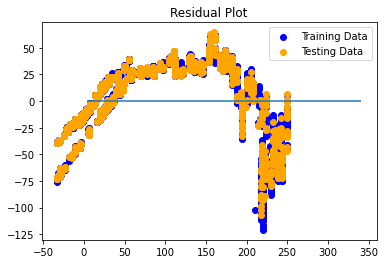

In [100]:
# Plot the Residuals for the Training and Testing data
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual Plot")

In [101]:
# Linear Regression: X_test predictions to variable
predictions = model.predict(X_test)

#### R2 Score is a very popular metric used for evaluating the performance of linear regression models. Where R2 Score is between 0 and 1, the closer to 1, the better the regression fit.
#### Use MSE or MAE when comparing two or more models, the lower the value of MSE or MAE, the better. MSE (Mean Square Error): Uses Euclidean distance to calculate the error. MSE gives the magnitude of the error only.

In [102]:
# Used X_test, y_test, and model.predict(X_test) to calculate MSE and R2

### BEGIN SOLUTION
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test, predictions)
r2 = model.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 1022.8838406783475, R2: 0.8724585079602966


#### Lasso regression imposes a constraint on the model parameters that causes regression coefficients for some variables to shrink toward zero. It comes with a parameter, alpha , and the higher the alpha , the more feature coefficients are zero. When alpha is 0 , Lasso regression produces the same coefficients as a linear regression.

In [103]:
# LASSO model
# Note: Used an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Lasso

### BEGIN SOLUTION
lasso = Lasso(alpha=.01).fit(X_train, y_train)

predictions = lasso.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = lasso.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 1022.866753833744, R2: 0.8724606384873107


In [104]:
# Ridge model
# Note: Used an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Ridge

### BEGIN SOLUTION
ridge = Ridge(alpha=.01).fit(X_train, y_train)

predictions = ridge.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = ridge.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 1022.8837769064131, R2: 0.8724585159119009


In [105]:
# ElasticNet model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import ElasticNet

### BEGIN SOLUTION
elasticnet = ElasticNet(alpha=.01).fit(X_train, y_train)

predictions = elasticnet.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = elasticnet.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 1022.767008398147, R2: 0.8724730755609786


# Hyperparameter Tuning

In [106]:
y_target = df_stock_less1["Close"]
y_target.shape

(5687,)

In [107]:
# Use train_test_split to create training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_target, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4265, 3) (4265,)
(1422, 3) (1422,)


In [108]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(4265, 3) (4265,)
(1422, 3) (1422,)


#### GridSearchCV and RandomizedSearchCV are techniques to evaluate models for a given hyperparameter vector using cross-validation, hence the “CV” suffix of the class name.
#### We are executing many models together is to find which machine learning model works best for this particular dataset.

In [109]:
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [110]:
regressors = [
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    KNeighborsRegressor(),
    ExtraTreesRegressor(),
    LinearRegression(),
    Lasso(),
    Ridge()
]

In [111]:
from time import time
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score

head = 10
for model in regressors[:head]:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print()

RandomForestRegressor()
	Training time: 0.219s
	Prediction time: 0.014s
	Explained variance: 0.997141488015024
	Mean absolute error: 2.5563905084704905
	R2 score: 0.9971408572127958

DecisionTreeRegressor()
	Training time: 0.002s
	Prediction time: 0.001s
	Explained variance: 0.9971081355889728
	Mean absolute error: 2.5659811105092243
	R2 score: 0.9971077391575989

KNeighborsRegressor()
	Training time: 0.005s
	Prediction time: 0.003s
	Explained variance: 0.9961850412525046
	Mean absolute error: 2.8080908174402244
	R2 score: 0.9961819858194645

GradientBoostingRegressor()
	Training time: 0.087s
	Prediction time: 0.002s
	Explained variance: 0.9968756825947571
	Mean absolute error: 2.8923546101202184
	R2 score: 0.9968745740678536

KNeighborsRegressor()
	Training time: 0.005s
	Prediction time: 0.003s
	Explained variance: 0.9961850412525046
	Mean absolute error: 2.8080908174402244
	R2 score: 0.9961819858194645

ExtraTreesRegressor()
	Training time: 0.132s
	Prediction time: 0.014s
	Explained 

#### By comparing these results, we can quickly see that RandomForestRegressor and DecisionTreeRegressor are the best models for our data
#### Machine learning models have parameters, which are the internal coefficients set by training or optimizing the model on a training dataset.
#### Parameters are different from hyperparameters. Parameters are learned automatically; hyperparameters are set manually to help guide the learning process.

In [112]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [113]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [114]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [115]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 80,
 'bootstrap': True}

In [116]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 2.5782 degrees.
Accuracy = 96.12%.
Model Performance
Average Error: 2.5575 degrees.
Accuracy = 96.15%.
Improvement of 0.03%.


In [117]:
# Hyperparameter tuning has not improved accuracy significantly

In [118]:
model_rfr = RandomForestRegressor()
model_rfr.fit(X_train, y_train)
y_test_pred = model_rfr.predict(X_test)
y_test_pred

array([ 29.68057544, 285.20757999,  15.85473066, ...,  86.21706771,
        33.74996649,  15.30531239])

In [119]:
#RandomForestRegressor Residual showing difference actual vs predicted
residual_dtr = pd.DataFrame([model_rfr.predict(X_train),y_train,(model_rfr.predict(X_train)-y_train)])
residual_dtr.tail

<bound method NDFrame.tail of          0          1         2         3          4          5          6     \
0  150.732424  32.780460  9.037147  6.291177  11.677752  37.495946  66.916724   
1  165.940002  33.540001  9.066666  5.983333  11.000000  37.970001  64.599998   
2  -15.207578  -0.759541 -0.029519  0.307844   0.677752  -0.474055   2.316726   

        7           8           9     ...        4255       4256        4257  \
0  90.449363  206.602395  280.930977  ...  107.414699  11.313098  273.058569   
1  82.949997  198.639999  301.720001  ...  100.059998  11.333333  278.640015   
2   7.499366    7.962396  -20.789024  ...    7.354701  -0.020235   -5.581446   

        4258       4259      4260       4261       4262       4263        4264  
0  34.233753  35.353447  4.833462  285.20758  92.230304  12.077512  300.083910  
1  32.720001  34.650002  4.466666  280.75000  90.669998  12.033333  300.959991  
2   1.513752   0.703445  0.366796    4.45758   1.560306   0.044179   -0.876081  


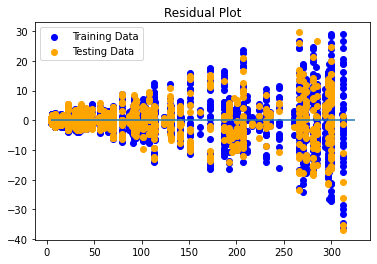

In [120]:
# Make predictions using fitted model
predictions1 = model_rfr.predict(X_test)

# Plotted the difference between the model predicted values and actual y values, versus the model predicted values
plt.scatter(model_rfr.predict(X_train), y_train - model_rfr.predict(X_train), c="blue", label="Training Data")
plt.scatter(model_rfr.predict(X_test), y_test - model_rfr.predict(X_test), c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")
plt.show()

# Save the Model

In [121]:
import pickle
filename = '../../static/csl_model_rfr.sav'
pickle.dump(model, open(filename, 'wb'))
model_in_rfr = pickle.load(open(filename, 'rb'))

In [122]:
# from joblib import dump,load
# model_in_rfr = load('CSL_model_rfr.sav')

In [123]:
rba = float(0.85)
fed = float(1.75)
cpi = float(125.00)
input =40
rfr=[]

def randomforest(rba,fed,cpi):
    for i in range(0,input):
      rfr.append([rba,fed,cpi])
      np.round_(rfr,2,out = None) 
      df = pd.DataFrame(rfr, columns = ['RBA','FED',"CPI"])
      df.round(2)
      pred_rf=model_in_rfr.predict(df)
      df['Prediction'] = pred_rf
      df['Prediction'] = df['Prediction'].astype(float).round(2)
      rba+=0.01
      fed+=0.01
      cpi+=0.01
      print(df)
    my_rforest = df.to_dict(orient='records')
    for dict_value in my_rforest:
      for k, v in dict_value.items():
        dict_value[k] = round(v, 2)
    return my_rforest
# print(my_rforest)
my_rf = randomforest(rba,fed,cpi)
print(my_rf)


    RBA   FED    CPI  Prediction
0  0.85  1.75  125.0      242.79
    RBA   FED     CPI  Prediction
0  0.85  1.75  125.00      242.79
1  0.86  1.76  125.01      242.73
    RBA   FED     CPI  Prediction
0  0.85  1.75  125.00      242.79
1  0.86  1.76  125.01      242.73
2  0.87  1.77  125.02      242.67
    RBA   FED     CPI  Prediction
0  0.85  1.75  125.00      242.79
1  0.86  1.76  125.01      242.73
2  0.87  1.77  125.02      242.67
3  0.88  1.78  125.03      242.61
    RBA   FED     CPI  Prediction
0  0.85  1.75  125.00      242.79
1  0.86  1.76  125.01      242.73
2  0.87  1.77  125.02      242.67
3  0.88  1.78  125.03      242.61
4  0.89  1.79  125.04      242.56
    RBA   FED     CPI  Prediction
0  0.85  1.75  125.00      242.79
1  0.86  1.76  125.01      242.73
2  0.87  1.77  125.02      242.67
3  0.88  1.78  125.03      242.61
4  0.89  1.79  125.04      242.56
5  0.90  1.80  125.05      242.50
    RBA   FED     CPI  Prediction
0  0.85  1.75  125.00      242.79
1  0.86  1.76  1

In [124]:
rba = float(0.85)
fed = float(1.75)
cpi = float(125.00)
def rforest(rba,fed,cpi):
    dtr =[[rba,fed,cpi]]
    df = pd.DataFrame (dtr, columns = ['RBA','FED',"CPI"])
    pred_dtr=model_in_rfr.predict(df)
    df['Prediction'] = pred_dtr
    print(df)
    df_dict = df.to_dict(orient='records')
    return pred_dtr
Pred_rf = rforest(rba,fed,cpi)
print(Pred_rf)

    RBA   FED    CPI  Prediction
0  0.85  1.75  125.0  242.787455
[242.78745497]


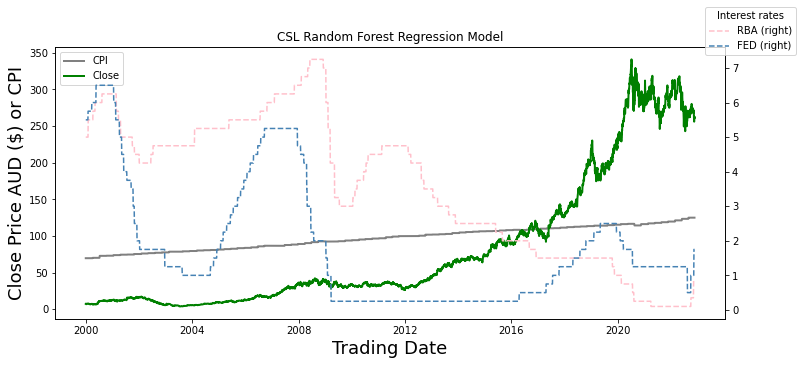

In [125]:
x = np.arange(2000,2024,4)
ax = df_stock_less1.plot(y=["CPI","Close"], figsize=(12, 5),color=['grey','green'],linewidth=2)
df_stock_less1.plot(y=["RBA","FED"],secondary_y=True, ax=ax,color=['pink','steelblue'],linestyle='dashed')
plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=-4, title="Interest rates")
ax.legend(loc='upper left')
ax.set_xticks([0,1000,2000,3000,4000,5000])
ax.set_xticklabels(x, rotation=0)
ax.set_title('CSL Random Forest Regression Model')
ax.set_xlabel('Trading Date', fontsize=18)
ax.set_ylabel('Close Price AUD ($) or CPI', fontsize=18)
plt.savefig('../../static/data/images/CSL_tree.png')

#Save predicted error to MongoDB

In [126]:
# Module used to connect Python with MongoDb
import pymongo

In [127]:
# The default port used by MongoDB is 27017
# https://docs.mongodb.com/manual/reference/default-mongodb-port/
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

# Define the 'sharesDB' database in Mongo
db = client.sharesDB.companys

In [128]:
# query the companys collection
companys = db.find()
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62be5c40e95d9c2fd3be8c1f'), 'model': 'LSTM', 'name': 'BHP', 'date': '28/06/2022', 'predicted': 40, 'actual': 42, 'differece': -2, 'rmse': 0.06586}
{'_id': ObjectId('62be7229a83f80add8272115'), 'model': 'LSTM', 'name': 'CBA', 'date': '28/06/2022', 'predicted': 88, 'actual': 93, 'differece': -5, 'rmse': 2.06539}
{'_id': ObjectId('62be73734cebc85c036027db'), 'model': 'LSTM', 'name': 'CSL', 'date': '28/06/2022', 'predicted': 269, 'actual': 274, 'differece': -5, 'rmse': 2.37099}
{'_id': ObjectId('62be74a49c5dda6983912be2'), 'model': 'LSTM', 'name': 'NAB', 'date': '28/06/2022', 'predicted': 27, 'actual': 27, 'differece': 0, 'rmse': 0.16451}
{'_id': ObjectId('62be74fb286df5ebd4ec3dc5'), 'model': 'LSTM', 'name': 'WBC', 'date': '28/06/2022', 'predicted': 20, 'actual': 19, 'differece': 1, 'rmse': 0.10867}
{'_id': ObjectId('62bea6cc0994fe23ecdfe680'), 'model': 'RFR', 'name': 'WBC', 'date': '23/06/2022', 'predicted': 31, 'actual': 19, 'differece': 12.953687103041862, 'accuracy': 

In [129]:
#save last price actual to variable
actual_price = df_stock3.iloc[-1,4]
actual_date = df_stock3.iloc[-1,0] 
actual_price = int(actual_price)
print(actual_price,actual_date,base_accuracy)


267 23/06/2022 96.11954066247928


In [130]:
# Set keys and values of company
name = 'CSL'
predicted = int(Pred_rf)
difference = Pred_rf-actual_price
print(f'date {actual_date},predicted {predicted},actual {actual_price}, difference {difference[0]}, accuracy {round(base_accuracy,2)}')

date 23/06/2022,predicted 242,actual 267, difference -24.21254503027103, accuracy 96.12


In [131]:
# Delete a document from a collection
db.delete_one(
    {'model': 'RFR','name': name}
)


In [132]:
# Insert a document into the 'companys' collection
db.insert_one(
    {
      'model': 'RFR',
      'name': name,
      'date': actual_date,
      'predicted': predicted,
      'actual': actual_price,
      'differece': difference[0],
      'accuracy': round(base_accuracy,2)        
    }
)

# query the classroom collection
companys = db.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62be5c40e95d9c2fd3be8c1f'), 'model': 'LSTM', 'name': 'BHP', 'date': '28/06/2022', 'predicted': 40, 'actual': 42, 'differece': -2, 'rmse': 0.06586}
{'_id': ObjectId('62be7229a83f80add8272115'), 'model': 'LSTM', 'name': 'CBA', 'date': '28/06/2022', 'predicted': 88, 'actual': 93, 'differece': -5, 'rmse': 2.06539}
{'_id': ObjectId('62be73734cebc85c036027db'), 'model': 'LSTM', 'name': 'CSL', 'date': '28/06/2022', 'predicted': 269, 'actual': 274, 'differece': -5, 'rmse': 2.37099}
{'_id': ObjectId('62be74a49c5dda6983912be2'), 'model': 'LSTM', 'name': 'NAB', 'date': '28/06/2022', 'predicted': 27, 'actual': 27, 'differece': 0, 'rmse': 0.16451}
{'_id': ObjectId('62be74fb286df5ebd4ec3dc5'), 'model': 'LSTM', 'name': 'WBC', 'date': '28/06/2022', 'predicted': 20, 'actual': 19, 'differece': 1, 'rmse': 0.10867}
{'_id': ObjectId('62bea6cc0994fe23ecdfe680'), 'model': 'RFR', 'name': 'WBC', 'date': '23/06/2022', 'predicted': 31, 'actual': 19, 'differece': 12.953687103041862, 'accuracy': 